#Dataset Info.

## train.csv [파일] 598(rows) * 2881(columns)
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 제품 품질 상태(Target) (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)
- Y_Quality : 제품 품질 수치
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수


## test.csv [파일]
- PRODUCT_ID : 제품의 고유 ID
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수


## sample_submission.csv [파일] - 제출 양식
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 예측한 제품 품질 상태 (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)

실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)
'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.

## 평가 산식 : Macro F1 Score
- Public score : 전체 테스트 데이터의 30%
- Private score : 전체 테스트 데이터의 100%

In [ ]:
import numpy as np
import pandas as pd
import os
import math
import random 

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/LGaimers/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/LGaimers/test.csv')

In [ ]:
train_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


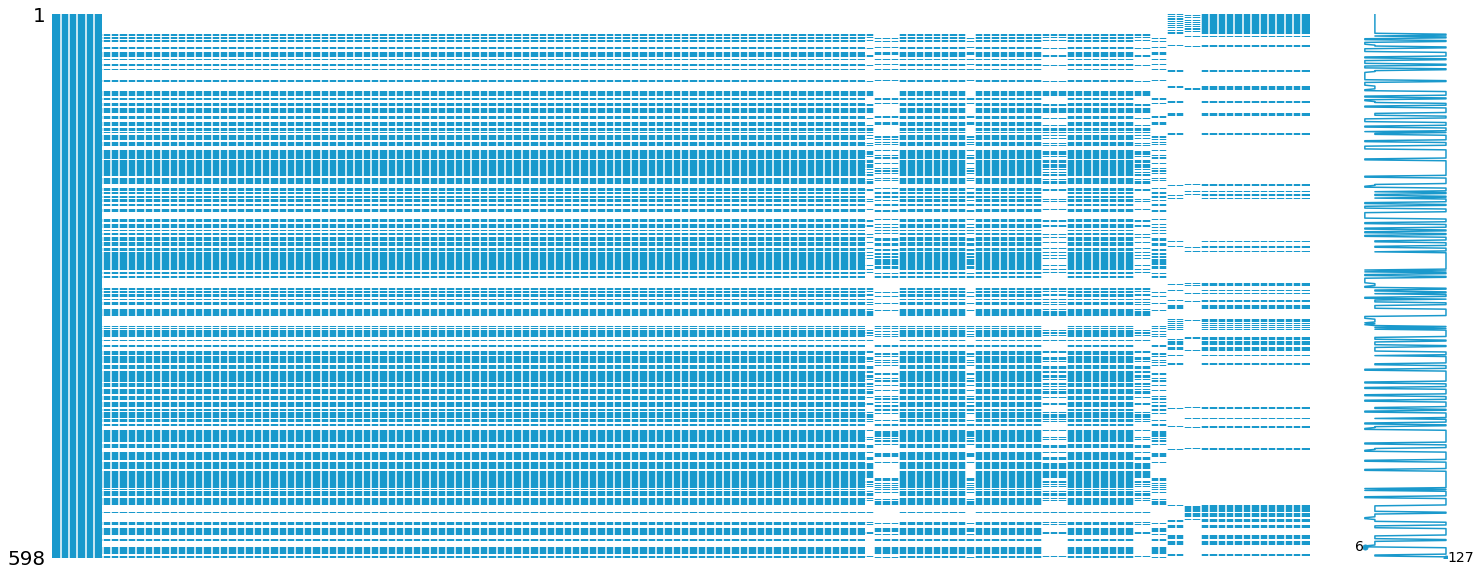

In [ ]:
msno.matrix(train_df.iloc[:,:150], color=(0.1, 0.6, 0.8))

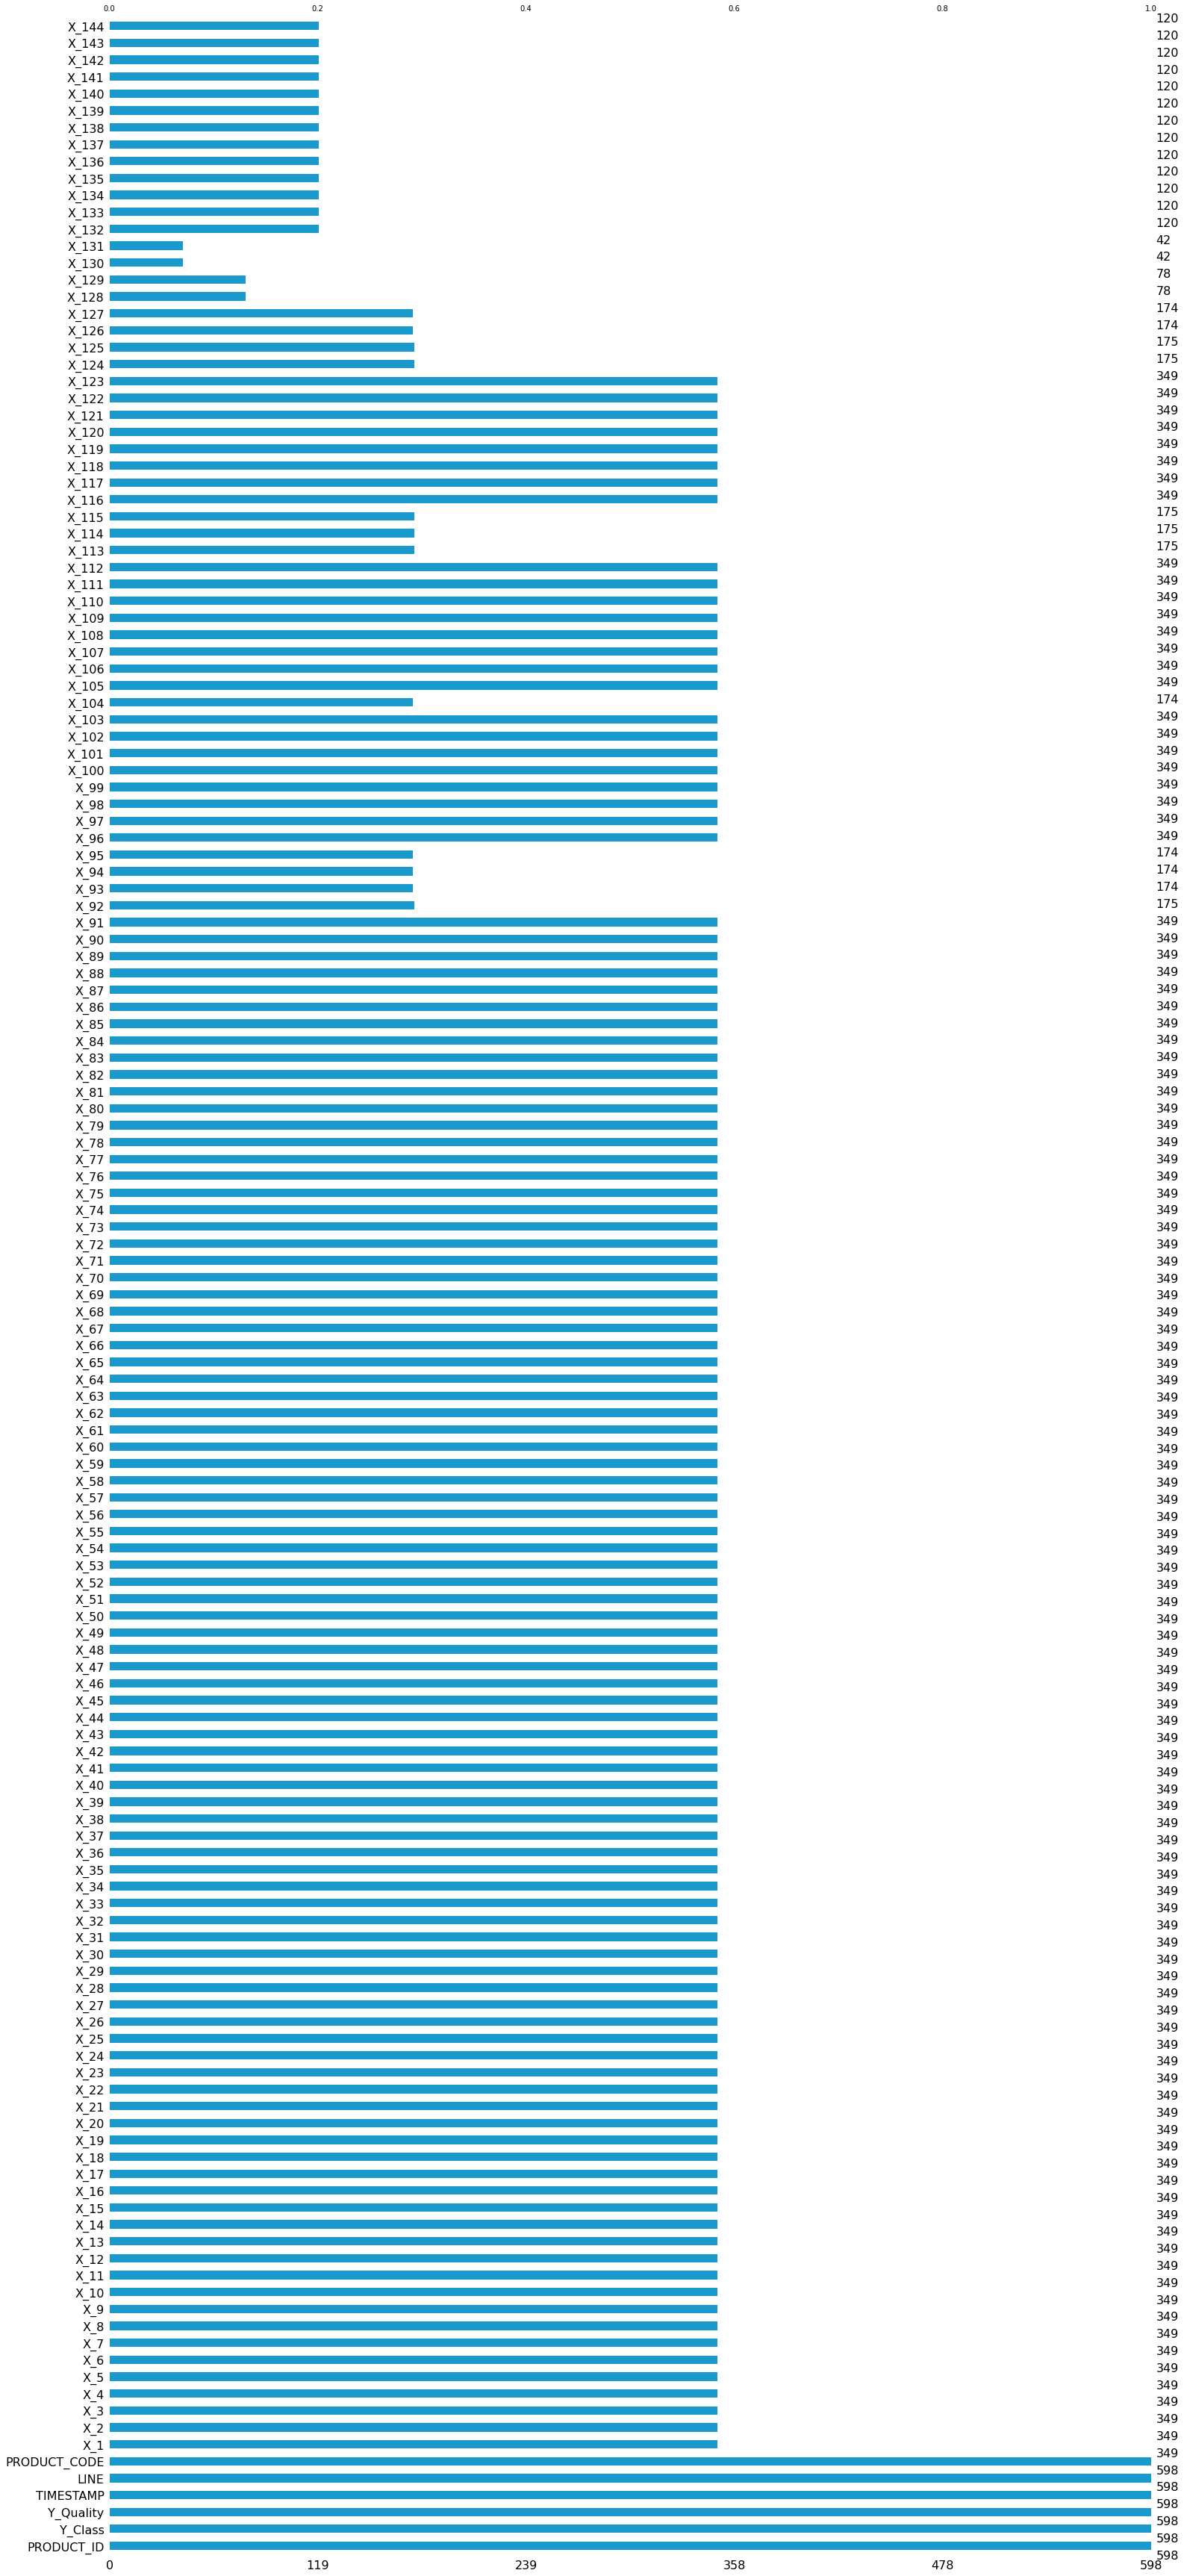

In [ ]:
msno.bar(train_df.iloc[:,:150], color=(0.1, 0.6, 0.8))

## Y_Class 별 data split

In [ ]:
below_standard_df = train_df[train_df['Y_Class']==0]
below_standard_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
22,TRAIN_022,0,0.517719,2022-06-14 8:53,T100304,T_31,2.0,102.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,TRAIN_023,0,0.519090,2022-06-14 9:01,T100304,T_31,2.0,102.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,TRAIN_028,0,0.521249,2022-06-19 20:26,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,TRAIN_034,0,0.521524,2022-06-21 17:36,T050304,A_31,NaN,NaN,NaN,NaN,...,55.03,52.24,55.33,57.49,67.31,1.0,NaN,NaN,NaN,NaN
66,TRAIN_066,0,0.524408,2022-06-25 21:38,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,TRAIN_583,0,0.522340,2022-09-05 8:34,T050304,A_31,NaN,NaN,NaN,NaN,...,51.71,59.64,54.61,57.05,63.18,1.0,NaN,NaN,NaN,NaN
584,TRAIN_584,0,0.519519,2022-09-05 11:09,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585,TRAIN_585,0,0.515214,2022-09-05 11:17,T010306,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN


In [ ]:
normal_standard_df = train_df[train_df['Y_Class']==1]
normal_standard_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
6,TRAIN_006,1,0.533665,2022-06-13 6:03,T050304,A_31,NaN,NaN,NaN,NaN,...,32.50,41.42,38.36,30.83,76.93,NaN,NaN,NaN,NaN,NaN
8,TRAIN_008,1,0.531821,2022-06-13 6:19,T050304,A_31,NaN,NaN,NaN,NaN,...,42.25,43.17,55.60,33.26,78.50,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,TRAIN_591,1,0.529308,2022-09-07 1:09,T100306,T_31,1.0,87.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
592,TRAIN_592,1,0.528349,2022-09-08 14:22,T100304,T_31,2.0,98.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
over_standard_df = train_df[train_df['Y_Class']==2]
over_standard_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
5,TRAIN_005,2,0.537833,2022-06-13 5:55,T050307,A_31,NaN,NaN,NaN,NaN,...,38.16,51.25,56.01,37.41,71.37,NaN,NaN,NaN,NaN,NaN
7,TRAIN_007,2,0.540003,2022-06-13 6:11,T050307,A_31,NaN,NaN,NaN,NaN,...,39.00,35.95,59.51,30.49,72.77,NaN,NaN,NaN,NaN,NaN
9,TRAIN_009,2,0.538049,2022-06-13 6:28,T050307,A_31,NaN,NaN,NaN,NaN,...,34.40,35.88,50.36,38.45,71.42,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,TRAIN_563,2,0.537465,2022-09-03 1:22,T050304,A_31,NaN,NaN,NaN,NaN,...,49.92,54.66,50.56,48.63,62.17,1.0,NaN,NaN,NaN,NaN
564,TRAIN_564,2,0.540106,2022-09-03 1:30,T050304,A_31,NaN,NaN,NaN,NaN,...,57.94,55.84,53.24,56.72,64.17,1.0,NaN,NaN,NaN,NaN
570,TRAIN_570,2,0.534951,2022-09-03 18:40,T100306,O_31,6.0,90.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572,TRAIN_572,2,0.535205,2022-09-03 18:56,T100306,O_31,6.0,89.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## PRODUCT CODE 별 data split

In [ ]:
A_31_df = train_df[train_df['PRODUCT_CODE']=='A_31']
A_31_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,TRAIN_583,0,0.522340,2022-09-05 8:34,T050304,A_31,NaN,NaN,NaN,NaN,...,51.71,59.64,54.61,57.05,63.18,1.0,NaN,NaN,NaN,NaN
584,TRAIN_584,0,0.519519,2022-09-05 11:09,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585,TRAIN_585,0,0.515214,2022-09-05 11:17,T010306,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN


In [ ]:
T_31_df = train_df[train_df['PRODUCT_CODE']=='T_31']
T_31_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
22,TRAIN_022,0,0.517719,2022-06-14 8:53,T100304,T_31,2.0,102.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,TRAIN_023,0,0.519090,2022-06-14 9:01,T100304,T_31,2.0,102.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,TRAIN_025,1,0.529362,2022-06-19 9:11,T100304,T_31,2.0,97.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,TRAIN_026,1,0.531992,2022-06-19 9:20,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,TRAIN_029,1,0.532405,2022-06-19 23:31,T100304,T_31,2.0,100.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,TRAIN_589,1,0.529510,2022-09-06 18:00,T100306,T_31,1.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590,TRAIN_590,1,0.529948,2022-09-07 1:01,T100306,T_31,1.0,89.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
591,TRAIN_591,1,0.529308,2022-09-07 1:09,T100306,T_31,1.0,87.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
592,TRAIN_592,1,0.528349,2022-09-08 14:22,T100304,T_31,2.0,98.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
O_31_df = train_df[train_df['PRODUCT_CODE']=='O_31']
O_31_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
569,TRAIN_569,1,0.530533,2022-09-03 18:32,T100304,O_31,4.0,98.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
570,TRAIN_570,2,0.534951,2022-09-03 18:40,T100306,O_31,6.0,90.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,TRAIN_571,1,0.525916,2022-09-03 18:48,T100304,O_31,4.0,100.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572,TRAIN_572,2,0.535205,2022-09-03 18:56,T100306,O_31,6.0,89.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,TRAIN_597,1,0.533702,2022-09-08 14:46,T100306,O_31,21.0,87.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


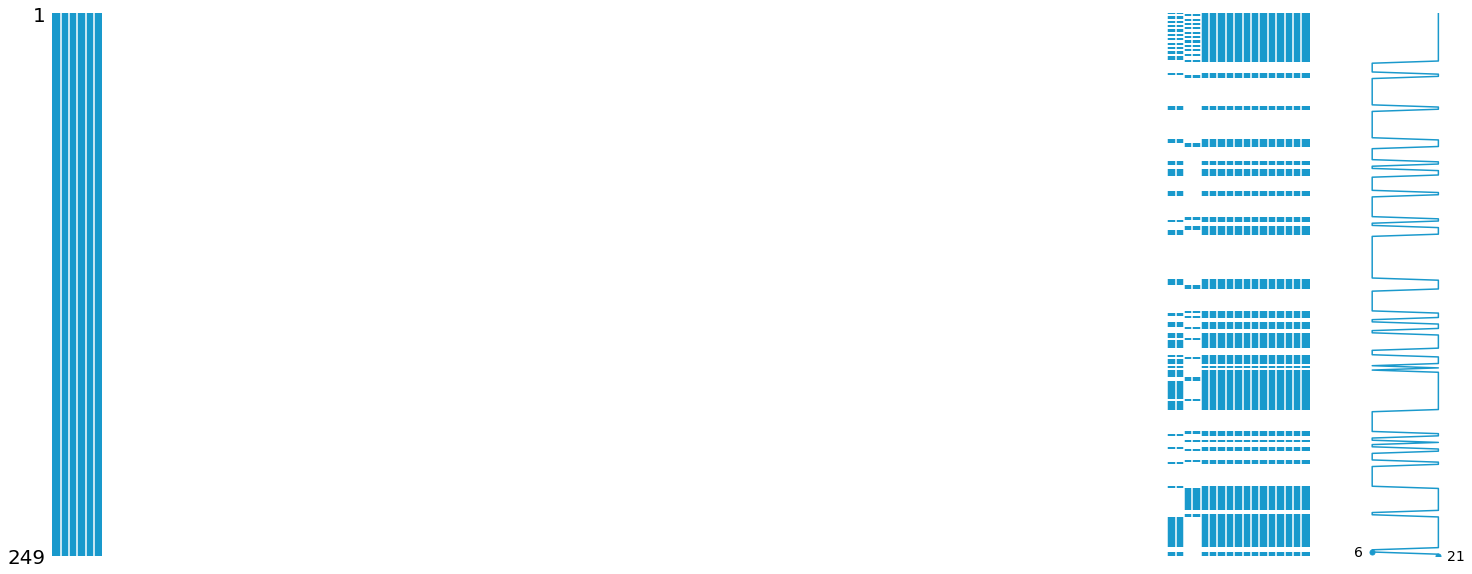

In [ ]:
msno.matrix(A_31_df.iloc[:,:150], color=(0.1, 0.6, 0.8))

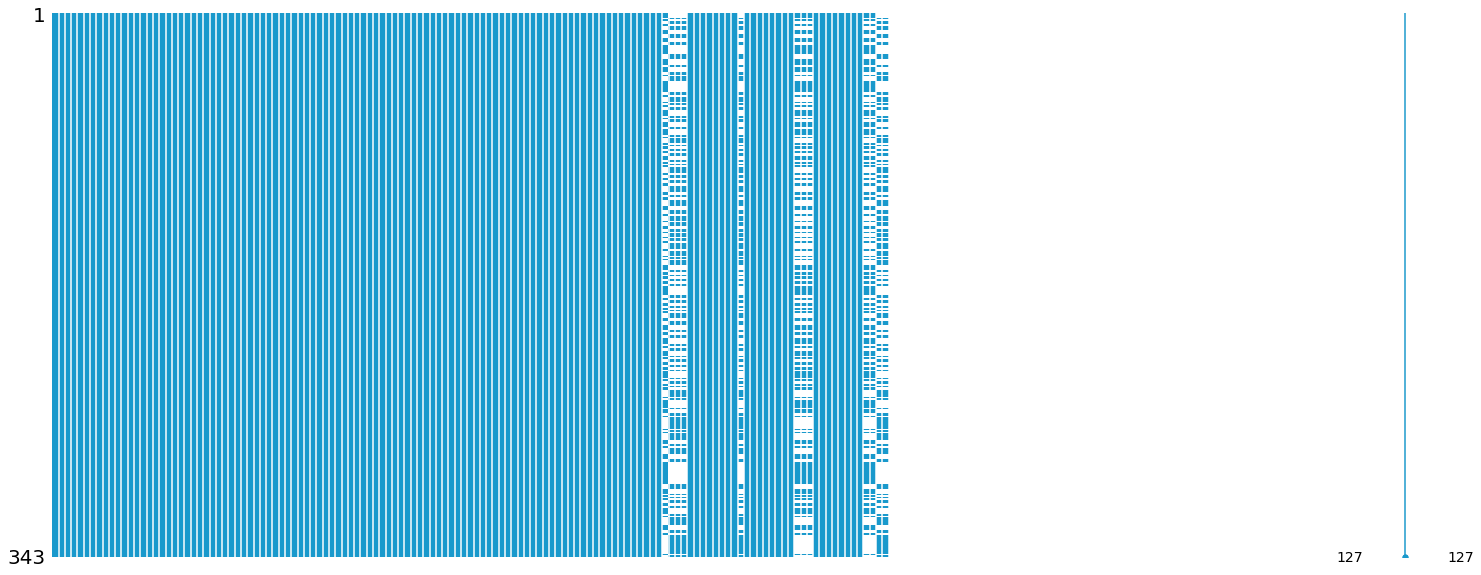

In [ ]:
msno.matrix(T_31_df.iloc[:,:200], color=(0.1, 0.6, 0.8))

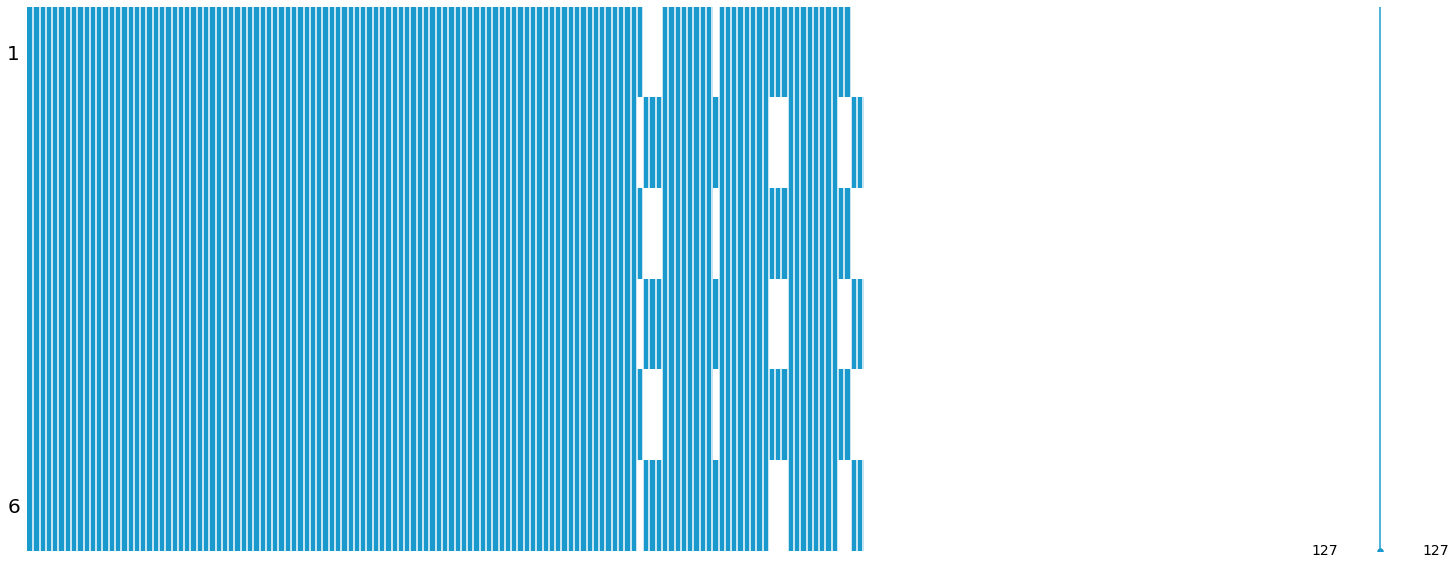

In [ ]:
msno.matrix(O_31_df.iloc[:,:200], color=(0.1, 0.6, 0.8))

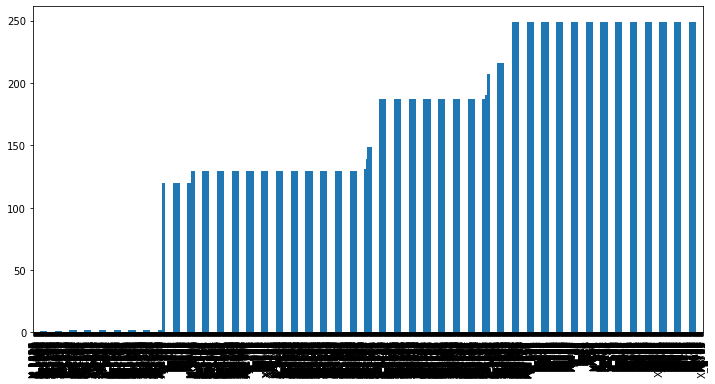

In [ ]:
missing = A_31_df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(figsize = (12,6))

## ISSUE

1. NaN 너무 많음 -> 단순히 결측치 처리 fillna(0)은 아닌듯
2. column 수 너무 많음 -> 다중공선성 확인하고 변수개수 줄일 수 있으면 best
3. PRODUCT CODE 별 ? Y_CLASS 별? 알아봐야할듯

## Insight

1. Y_Class 별로 살펴보면 Y_Quality 는 유의미한 변수가 될 것 같다. (베이스라인 코드에서는 drop 되어있음)
  - 실제로 Y_Quality 넣고 valid set 결과 Decision Tree 모델 f1_score 0. 69 -> 0.99로 상승.
  - test set에 Y_Qulity column이 없어서 만들어 내야할듯. 

2. Y_Class 와 Y_Quality는 기능상 정답(label)을 의미하는 건 똑같은듯.
  - Y_Class를 이용한 분류와
  - Y_Quality를 이용한 회귀를 비교하여 앙상블 하는 것도 괜찮을 것 같음

## brief conclusion

1. baseline(RandomForest) : f1 score(valid set) 0.73수준
  - train_x를 train_x와 valid_x로 split
  - 교차검증 안함
  - f1_score(average='micro')

2. DecisionTree : f1 score(valid set) 0.69 수준
  - train_x를 train_x와 valid_x로 split
  - 교차검증 안함
  - f1_score(average='micro')
  - 시각화 진행 -> root node 분기 기준 = X_1856